In [25]:
import pandas as pd #Dataframe, Series
import numpy as np

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns

import graphviz
import pydotplus
import io

from scipy import misc

from sklearn.metrics import accuracy_score

import spotipy
import spotipy.util as util
sp = spotipy.Spotify() 
from spotipy.oauth2 import SpotifyClientCredentials 

%matplotlib inline

### Login

In [26]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

client_id = '164fe11263da4ce8b39cb03311385ce6'
client_secret = '448a0146206e4b718e4bcc0865efcd29'
redirect_uri='http://localhost:8080/callback'
username = '5865b9eadfc54092'
scope = "user-library-read","playlist-modify-private"


#Credentials to access the Spotify Music Data
from spotipy.oauth2 import SpotifyOAuth
import spotipy

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id,
                                               client_secret,
                                               redirect_uri,
                                               scope = 'user-library-read playlist-read-private'))

### Input Data into Model

- gathering good and bad playlists
- The method signature is sp.user_playlist('user', 'playlist_id')
- To do this go to your good and bad playlists and copy the links.
    - An example spotify link: https://open.spotify.com/user/1287242681/playlist/5OdH7PmotfAO7qDGxKdw3J
    - The user is the number after user/ and the playlist id is after the playlist/.

In [27]:
good_playlist = sp.user_playlist("baacf740f3a541f9", "49fIpD0ywwbKeJoN6OfmgW")
# https://open.spotify.com/playlist/49fIpD0ywwbKeJoN6OfmgW?si=ac7c01e1a19d4cf1
bad_playlist = sp.user_playlist("baacf740f3a541f9", "37i9dQZF1EIeBK96mJllYR")
# https://open.spotify.com/playlist/12w4Scq6FS8FMvKBtAh2S9?si=480256fffbda480e

In [28]:
#Get the good song id's out of the good playlists, need it for the audio features call.
good_tracks = good_playlist["tracks"]
good_songs = good_tracks["items"] 
while good_tracks['next']:
    good_tracks = sp.next(good_tracks)
    for item in good_tracks["items"]:
        good_songs.append(item)
good_ids = [] 
print(len(good_songs))
for i in range(len(good_songs)- 500):
    good_ids.append(good_songs[i]['track']['id'])
# good_tracks

104


In [29]:
#Now do the same thing for the bad playlist
bad_tracks = bad_playlist["tracks"]
bad_songs = bad_tracks["items"] 
while bad_tracks['next']:
    bad_tracks = sp.next(bad_tracks)
    for item in bad_tracks["items"]:
        bad_songs.append(item)
bad_ids = [] 
print(len(bad_songs))
for i in range(len(bad_songs)):
    bad_ids.append(bad_songs[i]['track']['id'])

50


In [30]:
#Here is where we get all of the audio_features for the tracks on the good and bad playlists.
features = []
inSavedTracks = []
j = 0
for i in range(0,len(good_ids),50):
    print(i)
    audio_features = sp.audio_features(good_ids[i:i+50])
    for track in audio_features:
        features.append(track)
        track = good_songs[j]
        j= j+1
        features[-1]['trackPopularity'] = track['track']['popularity']
        features[-1]['artistPopularity'] = sp.artist(track['track']['artists'][0]['id'])['popularity']
        features[-1]['target'] = 1
j = 0
for i in range(0,len(bad_ids),50):
    audio_features = sp.audio_features(bad_ids[i:i+50])
    for track in audio_features:
        features.append(track)
        track = good_songs[j]
        j= j+1
        features[-1]['trackPopularity'] = track['track']['popularity']
        features[-1]['artistPopularity'] = sp.artist(track['track']['artists'][0]['id'])['popularity']
        features[-1]['target'] = 0

In [31]:
trainingData = pd.DataFrame(features)
trainingData.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,trackPopularity,artistPopularity,target
0,0.596,0.591,2,-9.254,0,0.0363,0.3400,0.005170,0.0970,0.135,...,audio_features,4poYvYKOKtpAOoXSIYeU0A,spotify:track:4poYvYKOKtpAOoXSIYeU0A,https://api.spotify.com/v1/tracks/4poYvYKOKtpA...,https://api.spotify.com/v1/audio-analysis/4poY...,185231,4,3,85.0,0
1,0.605,0.730,2,-12.092,1,0.0351,0.4010,0.000665,0.1250,0.867,...,audio_features,26kXONuhWX8sutaxnmcpPg,spotify:track:26kXONuhWX8sutaxnmcpPg,https://api.spotify.com/v1/tracks/26kXONuhWX8s...,https://api.spotify.com/v1/audio-analysis/26kX...,219867,4,0,68.0,0
2,0.609,0.430,8,-10.429,1,0.0363,0.5800,0.000000,0.1140,0.218,...,audio_features,5xWGpcvb1q6N1IIJwtDNRF,spotify:track:5xWGpcvb1q6N1IIJwtDNRF,https://api.spotify.com/v1/tracks/5xWGpcvb1q6N...,https://api.spotify.com/v1/audio-analysis/5xWG...,207880,4,0,85.0,0
3,0.592,0.966,9,-1.689,1,0.1310,0.0206,0.000000,0.3400,0.582,...,audio_features,59HKKV0eD3UPJ3RCG5qFcc,spotify:track:59HKKV0eD3UPJ3RCG5qFcc,https://api.spotify.com/v1/tracks/59HKKV0eD3UP...,https://api.spotify.com/v1/audio-analysis/59HK...,191163,4,0,85.0,0
4,0.614,0.986,2,-2.644,1,0.0529,0.1460,0.000000,0.0717,0.443,...,audio_features,4JoWZaASliMo4WISlnt8pL,spotify:track:4JoWZaASliMo4WISlnt8pL,https://api.spotify.com/v1/tracks/4JoWZaASliMo...,https://api.spotify.com/v1/audio-analysis/4JoW...,206213,4,75,85.0,0


In [32]:
train, test = train_test_split(trainingData, test_size = 0.15)
print("Training size: {}, Test size: {}".format(len(train),len(test)))

Training size: 42, Test size: 8


In [33]:
# Custom Color Palette for graphs
red_blue = ['#19B5FE', '#EF4836']
palette = sns.color_palette(red_blue)
sns.set_palette(palette)
sns.set_style('white')

In [34]:
pos_tempo = trainingData[trainingData['target'] == 1]['tempo']
neg_tempo = trainingData[trainingData['target'] == 0]['tempo']
pos_dance = trainingData[trainingData['target'] == 1]['danceability']
neg_dance = trainingData[trainingData['target'] == 0]['danceability']
pos_duration = trainingData[trainingData['target'] == 1]['duration_ms']
neg_duration = trainingData[trainingData['target'] == 0]['duration_ms']
pos_loudness = trainingData[trainingData['target'] == 1]['loudness']
neg_loudness = trainingData[trainingData['target'] == 0]['loudness']
pos_speechiness = trainingData[trainingData['target'] == 1]['speechiness']
neg_speechiness = trainingData[trainingData['target'] == 0]['speechiness']
pos_valence = trainingData[trainingData['target'] == 1]['valence']
neg_valence = trainingData[trainingData['target'] == 0]['valence']
pos_energy = trainingData[trainingData['target'] == 1]['energy']
neg_energy = trainingData[trainingData['target'] == 0]['energy']
pos_acousticness = trainingData[trainingData['target'] == 1]['acousticness']
neg_acousticness = trainingData[trainingData['target'] == 0]['acousticness']
pos_key = trainingData[trainingData['target'] == 1]['key']
neg_key = trainingData[trainingData['target'] == 0]['key']
pos_instrumentalness = trainingData[trainingData['target'] == 1]['instrumentalness']
neg_instrumentalness = trainingData[trainingData['target'] == 0]['instrumentalness']
pos_popularity = trainingData[trainingData['target'] == 1]['trackPopularity']
neg_popularity = trainingData[trainingData['target'] == 0]['trackPopularity']

In [35]:
print(pos_popularity)
print(neg_popularity)

Series([], Name: trackPopularity, dtype: int64)
0      3
1      0
2      0
3      0
4     75
5     71
6     71
7     70
8     64
9     69
10     0
11    74
12    61
13    44
14     0
15     0
16    61
17    54
18    40
19    62
20     1
21     6
22    65
23    61
24    82
25    80
26    70
27    48
28    76
29    53
30    58
31    55
32    80
33     0
34     0
35    77
36    71
37    54
38     1
39     0
40    68
41    35
42    54
43     0
44    58
45    46
46    82
47     0
48    53
49    42
Name: trackPopularity, dtype: int64


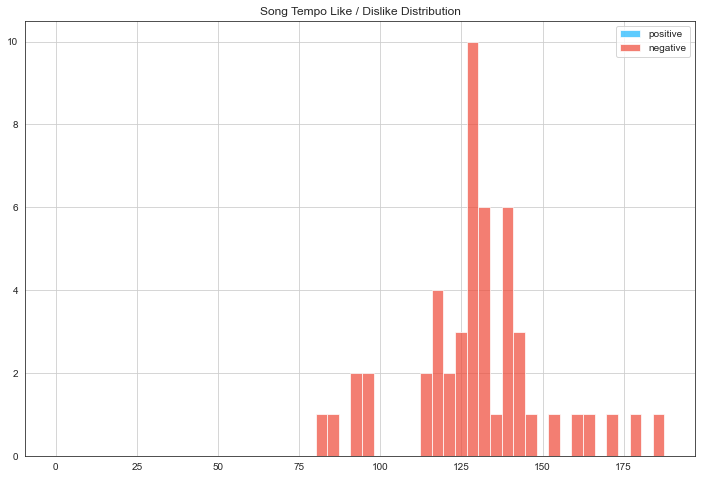

In [36]:
fig = plt.figure(figsize=(12,8))
plt.title("Song Tempo Like / Dislike Distribution")
pos_tempo.hist(alpha=0.7, bins=30, label='positive')
neg_tempo.hist(alpha=0.7, bins=30, label='negative')
plt.legend(loc='upper right')

<AxesSubplot: >

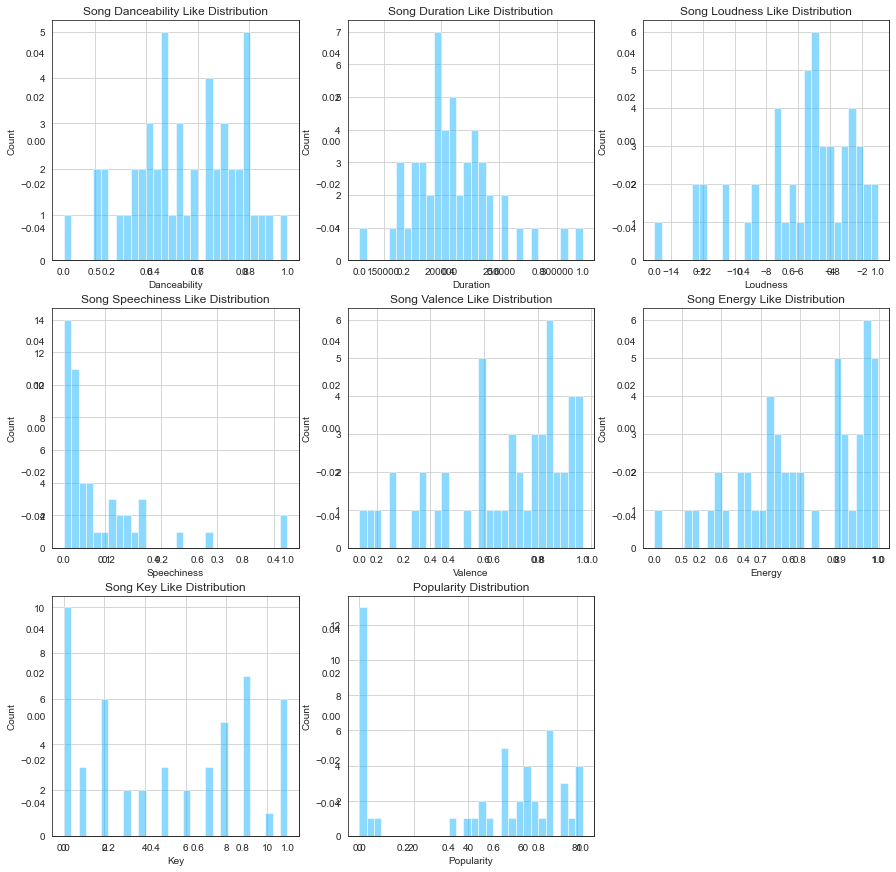

In [37]:
fig2 = plt.figure(figsize=(15,15))

#Danceability
ax3 = fig2.add_subplot(331)
ax3.set_xlabel('Danceability')
ax3.set_ylabel('Count')
ax3.set_title('Song Danceability Like Distribution')
pos_dance.hist(alpha= 0.5, bins=30)
ax4 = fig2.add_subplot(331)
neg_dance.hist(alpha= 0.5, bins=30)

#Duration_ms
ax5 = fig2.add_subplot(332)
ax5.set_xlabel('Duration')
ax5.set_ylabel('Count')
ax5.set_title('Song Duration Like Distribution')
pos_duration.hist(alpha= 0.5, bins=30)
ax6 = fig2.add_subplot(332)
neg_duration.hist(alpha= 0.5, bins=30)

#Loudness
ax7 = fig2.add_subplot(333)
ax7.set_xlabel('Loudness')
ax7.set_ylabel('Count')
ax7.set_title('Song Loudness Like Distribution')
pos_loudness.hist(alpha= 0.5, bins=30)
ax8 = fig2.add_subplot(333)
neg_loudness.hist(alpha= 0.5, bins=30)

#Speechiness
ax9 = fig2.add_subplot(334)
ax9.set_xlabel('Speechiness')
ax9.set_ylabel('Count')
ax9.set_title('Song Speechiness Like Distribution')
pos_speechiness.hist(alpha= 0.5, bins=30)
ax10 = fig2.add_subplot(334)
neg_speechiness.hist(alpha= 0.5, bins=30)

#Valence
ax11 = fig2.add_subplot(335)
ax11.set_xlabel('Valence')
ax11.set_ylabel('Count')
ax11.set_title('Song Valence Like Distribution')
pos_valence.hist(alpha= 0.5, bins=30)
ax12 = fig2.add_subplot(335)
neg_valence.hist(alpha= 0.5, bins=30)

#Energy
ax13 = fig2.add_subplot(336)
ax13.set_xlabel('Energy')
ax13.set_ylabel('Count')
ax13.set_title('Song Energy Like Distribution')
pos_energy.hist(alpha= 0.5, bins=30)
ax14 = fig2.add_subplot(336)
neg_energy.hist(alpha= 0.5, bins=30)

#Key
ax15 = fig2.add_subplot(337)
ax15.set_xlabel('Key')
ax15.set_ylabel('Count')
ax15.set_title('Song Key Like Distribution')
pos_key.hist(alpha= 0.5, bins=30)
ax16 = fig2.add_subplot(337)
neg_key.hist(alpha= 0.5, bins=30)

#Key
ax15 = fig2.add_subplot(338)
ax15.set_xlabel('Popularity')
ax15.set_ylabel('Count')
ax15.set_title('Popularity Distribution')
pos_popularity.hist(alpha= 0.5, bins=30)
ax16 = fig2.add_subplot(338)
neg_popularity.hist(alpha= 0.5, bins=30)
